In [1]:
import torch
import torch.fft as fft

Array = torch.Tensor

from torch_cfd.grids import *
from torch_cfd.equations import *
from torch_cfd.initial_conditions import *
from torch_cfd.finite_differences import *
from torch_cfd.forcings import *

import xarray
import seaborn as sns
from tqdm.auto import tqdm

torch.set_default_dtype(torch.float64)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [2]:
n = 512
diam = 2 * torch.pi
dt = 1e-3
T = 10
num_steps = int(T / dt)
num_snapshots = 100
record_iters = int(num_steps / num_snapshots)
max_velocity = 7
peak_wavenumber = 4
scale = 1
random_state = 0
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)


grid = Grid(shape=(n, n), domain=((0, diam), (0, diam)), device=device)

v0 = filtered_velocity_field(grid, max_velocity, peak_wavenumber, random_state=random_state)

vort_init = curl_2d(v0).data
vort_hat = fft.rfft2(vort_init).to(device)


forcing_fn = KolmogorovForcing(grid=grid, 
                                scale=scale, 
                                k=peak_wavenumber)

ns2d = NavierStokes2DSpectral(
    viscosity=1e-3, 
    grid=grid, 
    drag=0.1, 
    smooth=True, 
    forcing_fn=forcing_fn,
    solver=crank_nicolson_rk4
).to(device)

In [3]:
result = ns2d.get_trajectory(vort_hat, dt, T, 
                 record_every_steps=record_iters,
                 pbar=True
                 )
vort = fft.irfft2(result['vorticity']).cpu()
velocity = fft.irfft2(result['velocity']).cpu()
vort_t = fft.irfft2(result['vort_t']).cpu()

  0%|          | 0/10000 [00:00<?, ?it/s]

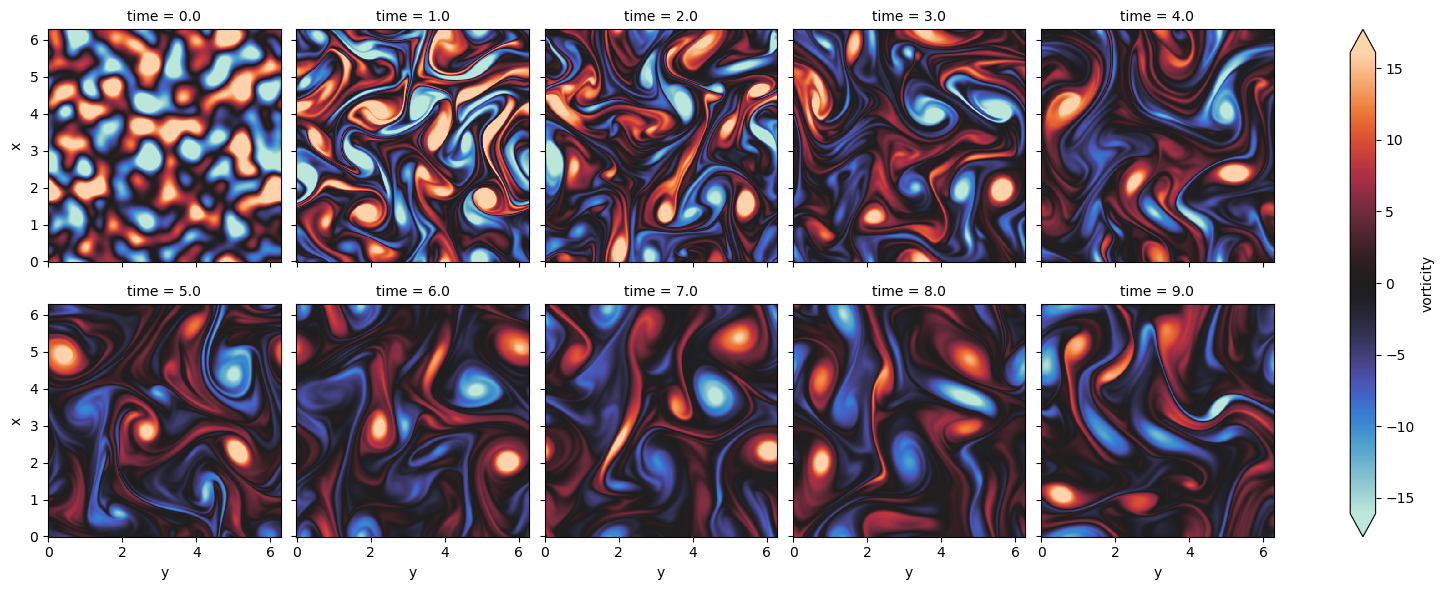

In [4]:
spatial_coord = torch.arange(n) * 2 * torch.pi / n # same for x and y
coords = {
  'time': record_iters * dt * torch.arange(num_snapshots),
  'x': spatial_coord,
  'y': spatial_coord,
}

w_data = xarray.DataArray(
    torch.cat([vort_init[None, ...].cpu(), vort], dim=0)[:-1],
    dims=["time", "x", "y"], 
    coords=coords).to_dataset(name='vorticity')

w_data['vorticity'].thin(time=10).plot.imshow(
        col='time', col_wrap=5, cmap=sns.cm.icefire, robust=True);

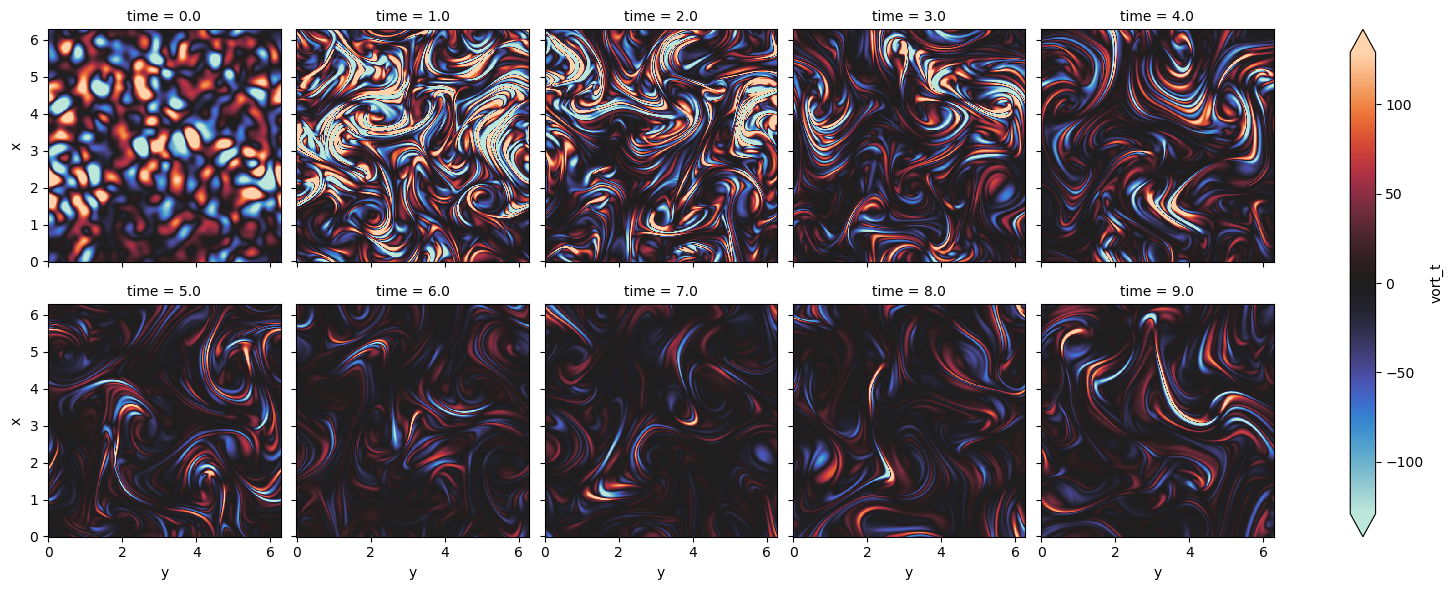

In [5]:
wt_data = xarray.DataArray(
    vort_t,
    dims=["time", "x", "y"], 
    coords=coords).to_dataset(name='vort_t')
wt_data['vort_t'].thin(time=10).plot.imshow(
        col='time', col_wrap=5, cmap=sns.cm.icefire, robust=True);

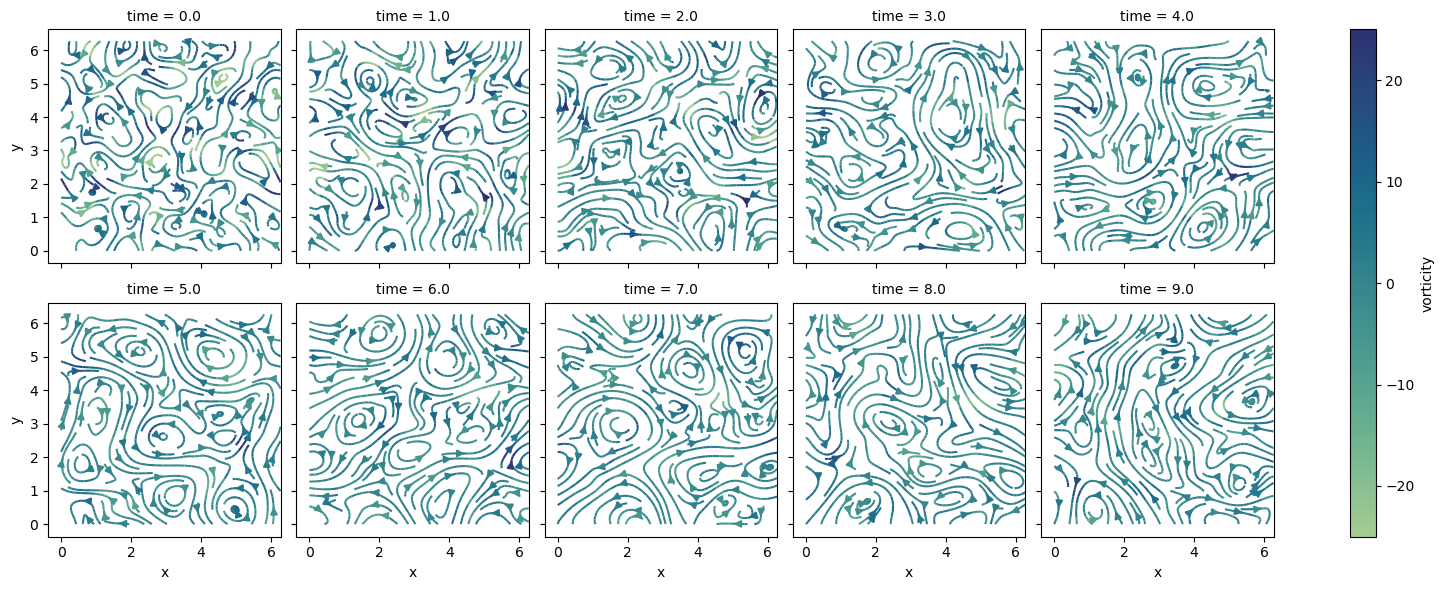

In [6]:
u_data = xarray.DataArray(
    velocity[:, 0],
    dims=["time", "x", "y"], 
    coords=coords).to_dataset(name='u')

v_data = xarray.DataArray(
    velocity[:, 1],
    dims=["time", "x", "y"], 
    coords=coords).to_dataset(name='v')

data = xarray.merge([u_data, v_data, w_data])

data.thin(time=10).plot.streamplot(
    x="x",
    y="y",
    u="u",
    v="v",
    hue='vorticity',
    col='time', 
    col_wrap=5,
    cmap=sns.cm.crest,
    vmin=-25,
    vmax=25,
);